# Question Answer 2 (haystack v.2)

We will get back to the QA problem of yesterday, this time focusing on evaluating the retriver and reader separately, and implementing a RAG model for our problem. We will not fine-tune here, as haystack dropped FARM in Version 2 (we could train in HF directly, but the data strcuture is *very* messy). Refer to the v.1 notebook for training in 1.24.

## Reloading the dataset
I will not comment a lot here, as this is mostly work from yesterday. Instead of using Elasticsearch, however, we will play with InMemory store (given the size of the dataset, it should hardly matter). We will also migrate to haystack 2, as working with RAGs becomes significantly easier.
Finially, we use a dense retriever instead of BM25.

In [1]:
import haystack
print(haystack.__version__)


2.20.0


In [2]:
from datasets import load_dataset
subjqa = load_dataset("subjqa", name="electronics", trust_remote_code = True)

import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To be able to use the dense embdding, we will need to update the retriever.

In [3]:
from haystack.components.embedders import SentenceTransformersTextEmbedder, SentenceTransformersDocumentEmbedder

dense = SentenceTransformersDocumentEmbedder(model = 'sentence-transformers/all-MiniLM-L6-v2')
dense.warm_up() # Downloads model


from haystack import Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
document_store_dense = InMemoryDocumentStore(embedding_similarity_function = "cosine")

for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [Document(content =  row["context"], 
             meta = {"item_id": row["title"], "question_id": row["id"], 
                     "split": split, 'review_id': row['review_id'] })
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    documents_with_embeddings = dense.run(docs)['documents']
    document_store_dense.write_documents(
        documents_with_embeddings
        )
print(f"Loaded {document_store_dense.count_documents()} documents to dense")

Batches: 100%|██████████| 8/8 [00:00<00:00, 16.66it/s]

Loaded 1875 documents to dense


## Evaluating retrievers
Here we will compare the two retrievers separately to see how well they perform. We need to update the book's code for that! In Haystack $\geq$ 2.00, the retriever needs to first apply the dense embedding to the query, so that the cosine simalirity (or any other simlarity we use) can be computed. Let us see how to do this.

In [10]:
from haystack import Pipeline
from haystack.components.retrievers import InMemoryEmbeddingRetriever

query_pipeline = Pipeline()
query_pipeline.add_component("text_embedder", SentenceTransformersTextEmbedder(model = 'sentence-transformers/all-MiniLM-L6-v2'))
query_pipeline.add_component("retriever", InMemoryEmbeddingRetriever(document_store = document_store_dense))
query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (list[float])

We can test it.

In [43]:
# Makes evaluation dataset.
eval_data = []
for i, row in dfs['test'].iterrows():
    # Deals with aswerable questions
    if len(row['answers.text']):
        eval_data.append({
            'query': row['question'],
            'item_id': row['title'],
            'expected': row['review_id']
        })
    # Unanswarable
    else:
        eval_data.append({
                'query': row['question'],
                'item_id': row['title'],
                'expected': ''
            })

In [59]:
query = eval_data[-1]['query']

query_pipeline.run({
    "retriever": {
        "filters": {
            "operator": "AND",
            "conditions": [
                {
                    "field": "item_id",
                    "operator": "==",
                    "value": eval_data[-1]["item_id"]
                },
                {
                    "field": "split",
                    "operator": "==",
                    "value": "test"
                }
            ]
        }
    },
    "text_embedder": {"text": query}
})

print('Expected id:', eval_data[-1]['expected'])
print('Retrived id:', result['retriever']['documents'][0].meta['review_id'])

Batches: 100%|██████████| 1/1 [00:00<00:00, 401.64it/s]

Expected id: 62f620f40a54e9c966efffd0ee44a155
Retrived id: 62f620f40a54e9c966efffd0ee44a155


Let us implement recall@1

Batches: 100%|██████████| 1/1 [00:00<00:00, 415.61it/s]


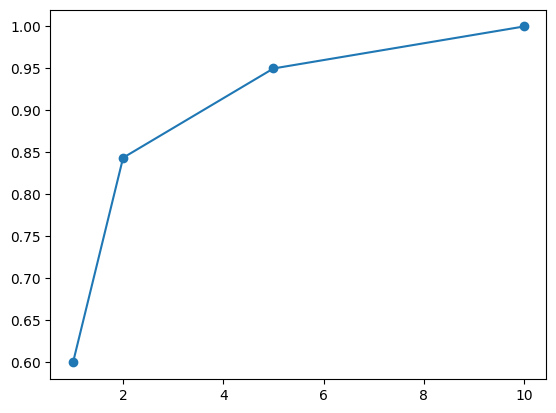

In [58]:
recalls = []
ks = [1, 2, 5, 10]
for k in ks:
    recall = 0
    questions_answered = 0

    for item in eval_data:
        query = item['query']
        item_id = item['item_id']
        retrieved_docs = query_pipeline.run({
                "retriever": {
                    "filters": {
                        "operator": "AND",
                        "conditions": [
                            {
                                "field": "item_id",
                                "operator": "==",
                                "value": item_id
                            },
                            {
                                "field": "split",
                                "operator": "==",
                                "value": "test"
                            }
                        ]
                    },
                    'top_k': k
                },
                "text_embedder": {"text": query}
            })['retriever']['documents']
        retrieved_texts = [doc.meta['review_id'] for doc in retrieved_docs]

        # Recall is the number of corrected retrieved in the expected set
        # Because the expected set is here just one document, it is easy
        retrieved_set = retrieved_texts[:k]

        # Deals with unsanswerable questions by skipping the rest of iteration
        if len(item['expected']) == 0:
            continue
        if item['expected'] in retrieved_set:
            recall += 1
        
        questions_answered += 1

    recalls.append(recall/questions_answered)

import matplotlib.pyplot as plt
plt.plot(ks, recalls, 'o-')
plt.show()

Nice!

## Reader

Let us evaluate the reader. This turns out to be very easy, as we can just reuse the SQUAD metric.

In [25]:
import evaluate

squad_metric = evaluate.load("squad")

We initialize the reader.

In [6]:
from haystack.components.readers import ExtractiveReader
model_ckpt = "deepset/minilm-uncased-squad2"

reader = ExtractiveReader(
    model = model_ckpt
)
reader.warm_up()

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We can test it.

In [67]:
docs = [Document(content="Paris is the capital of France."), Document(content="Berlin is the capital of Germany.")]
reader.run(query="What is the capital of France?", documents=docs, top_k=2)

{'answers': [ExtractedAnswer(query='What is the capital of France?', score=0.7738962769508362, data='Paris', document=Document(id=0f5beda04153dbfc462c8b31f8536749e43654709ecf0cfe22c6d009c9912214, content: 'Paris is the capital of France.'), context=None, document_offset=ExtractedAnswer.Span(start=0, end=5), context_offset=None, meta={}),
  ExtractedAnswer(query='What is the capital of France?', score=0.4139561653137207, data='France', document=Document(id=0f5beda04153dbfc462c8b31f8536749e43654709ecf0cfe22c6d009c9912214, content: 'Paris is the capital of France.'), context=None, document_offset=ExtractedAnswer.Span(start=24, end=30), context_offset=None, meta={}),
  ExtractedAnswer(query='What is the capital of France?', score=0.13250669289257644, data=None, document=None, context=None, document_offset=None, context_offset=None, meta={})]}

Or on our data.

In [4]:
eval_data = []
for i, row in dfs['test'].iterrows():
    # Deals with aswerable questions
    if len(row['answers.text']):
        eval_data.append({
            'query': row['question'],
            'expected': list(row['answers.text']),
            'start': list(row['answers.answer_start']),
            'context': row['context'],
            'id': row['id']
        })
    # Unanswarable
    else:
        eval_data.append({
            'query': row['question'],
            'expected': [''],
            'start': [0],
            'context': row['context'],
            'id': row['id']
        })

In [84]:
item = eval_data[-1]
reader.run(query = item['query'], documents = [Document(content =  item['context'])], top_k = 1)['answers'][0].data

'durable'

In [89]:
preds = []
refs = []

for item in eval_data:
    pred = reader.run(
        query = item['query'], 
        top_k = 1,
        documents = [Document(content =  item['context'])]
        )  

    pred = pred['answers'][0].data
    # Cannot evaluate with an empty string, so we give it a dummy
    if pred is None:
        pred = ''

    
    preds.append({
        'id': item['id'],
        'prediction_text': pred
    })
    
    ctext = item['expected']
    cstart = item['start']

    refs.append({
        'id': item['id'],
        'answers': {'text': ctext, 
                    'answer_start': cstart}
    })

squad_metric.compute(predictions = preds, references = refs)

{'exact_match': 5.865921787709497, 'f1': 12.723288374711998}

As expected, we got the same results from yesterday. Nonetheless, these are a little worse than what is reported by the book. The reason can be due to implementation of SQUAD (we implemented using Hugging Face, whereas they use the old haystack implementation). Nonetheless, since we are about 1/2 of their result and, incidently, about these much questions are unswered in the datatset, it can be on how each implementation deals with unswerables.

## Retriever + Reader

Again, this is basic code from yesterday.

In [16]:
pipe = Pipeline()
""
pipe.add_component("text_embedder", SentenceTransformersTextEmbedder(model = 'sentence-transformers/all-MiniLM-L6-v2'))
pipe.add_component("retriever", InMemoryEmbeddingRetriever(document_store = document_store_dense))
pipe.add_component("reader", reader)

pipe.connect("text_embedder.embedding", "retriever.query_embedding")
pipe.connect("retriever.documents", "reader.documents")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - reader: ExtractiveReader
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (list[float])
  - retriever.documents -> reader.documents (list[Document])

In [5]:
# Makes evaluation dataset.
eval_data = []
for i, row in dfs['test'].iterrows():
    # Deals with aswerable questions
    if len(row['answers.text']):
        eval_data.append({
            'query': row['question'],
            'item_id': row['title'],
            'expected': row['answers.text'],
            'start': row['answers.answer_start'],
            'id': row['id']

        })
    # Unanswarable
    else:
        eval_data.append({
                'query': row['question'],
                'item_id': row['title'],
                'expected': '',
                'start': row['answers.answer_start'],
                'id': row['id']

            })

In [18]:
query = eval_data[-1]['query']

result = pipe.run({
    "retriever": {
        "filters": {
            "operator": "AND",
            "conditions": [
                {
                    "field": "item_id",
                    "operator": "==",
                    "value": eval_data[-1]["item_id"]
                },
                {
                    "field": "split",
                    "operator": "==",
                    "value": "test"
                }
            ]
        }
    },
    "text_embedder": {"text": query},
    "reader": {"query": query}
})

print('Query:', query)
print('Expected answer:', eval_data[-1]['expected'][0])
print('Predicted answer:', result['reader']['answers'][0].data)


Batches: 100%|██████████| 1/1 [00:00<00:00, 137.27it/s]

Query: What about case?
Expected answer: The Gladius mini is a durable case
Predicted answer: durable


In [201]:
k = 10
preds = []
refs = []
for rev in eval_data:
    pred =  pipe.run({
    "retriever": {
        "filters": {
            "operator": "AND",
            "conditions": [
                {
                    "field": "item_id",
                    "operator": "==",
                    "value": rev["item_id"]
                },
                {
                    "field": "split",
                    "operator": "==",
                    "value": "test"
                }
            ]
        },
        'top_k': k,
    },
    "text_embedder": {"text": query},
    "reader": {"query": query}
})
    pred = pred['reader']['answers']
    # Cannot evaluate with an empty string, so we give it a dummy
    if pred == []:
        pred = ''
    else:
        pred =  pred[0].data
    
    
    preds.append({
        'id': rev['id'],
        'prediction_text': pred
    })
    
    if len(rev['expected']) == 0:
        ctext = ['']
        cstart = [0]
    else:
        ctext = list(rev['expected'])
        cstart = list(rev['start'])

    refs.append({
        'id': rev['id'],
        'answers': {'text': ctext, 
                    'answer_start': cstart}
    })

squad_metric.compute(predictions = preds, references = refs)

Batches: 100%|██████████| 1/1 [00:00<00:00, 428.08it/s]


{'exact_match': 0.8379888268156425, 'f1': 5.015624217740161}

Still bad, but somewhat expected. We note that the reader responses are extremely short and, for this reson, the performance is not so great. Moreover, we can understand the fact that the retriever recall is almost perfect, but performance drops a lot by noticing that, the *recall* measures how many of the correct documents are being caught, but if we are catching many documents, the reader can get confused. See that performance actually improves by decreasing k.

In [203]:
k = 3
preds = []
refs = []
for rev in eval_data:
    pred =  pipe.run({
    "retriever": {
        "filters": {
            "operator": "AND",
            "conditions": [
                {
                    "field": "item_id",
                    "operator": "==",
                    "value": rev["item_id"]
                },
                {
                    "field": "split",
                    "operator": "==",
                    "value": "test"
                }
            ]
        },
        'top_k': k,
    },
    "text_embedder": {"text": query},
    "reader": {"query": query}
})
    pred = pred['reader']['answers']
    # Cannot evaluate with an empty string, so we give it a dummy
    if pred == []:
        pred = ''
    else:
        pred =  pred[0].data
    
    
    preds.append({
        'id': rev['id'],
        'prediction_text': pred
    })
    
    if len(rev['expected']) == 0:
        ctext = ['']
        cstart = [0]
    else:
        ctext = list(rev['expected'])
        cstart = list(rev['start'])

    refs.append({
        'id': rev['id'],
        'answers': {'text': ctext, 
                    'answer_start': cstart}
    })

squad_metric.compute(predictions = preds, references = refs)

Batches: 100%|██████████| 1/1 [00:00<00:00, 409.88it/s]


{'exact_match': 1.1173184357541899, 'f1': 5.166934878567918}

# RAGs

RAGs are basically QA models but, instead of a reader, we have a generative model giving us the answers. For fun now, we will implement a RAG using haystack.

In [21]:
from haystack.components.generators import HuggingFaceLocalGenerator

generator = HuggingFaceLocalGenerator(model="google/flan-t5-small",
                                      task="text2text-generation",
                                      generation_kwargs={
                                        "max_new_tokens": 30,
                                        "temperature": 0.5,
                                        })

RAGs are a little bit different, though. Instead of giving only the query, we need to give a prompt (think exactly of Chat GPT). So we will use a prompt builder, which basically fits the prompt into the correct template.

In [18]:
from haystack.components.builders.prompt_builder import PromptBuilder

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}
100
Question: {{ query }}?
"""

Now we give the pipeline structure.

In [22]:
pipe = Pipeline()

# We cannot call dense here because it is already part of another pipeline, so we need to redefine it
pipe.add_component("text_embedder", SentenceTransformersTextEmbedder(model = 'sentence-transformers/all-MiniLM-L6-v2'))
pipe.add_component("retriever", InMemoryEmbeddingRetriever(document_store = document_store_dense))
pipe.add_component("prompt_builder", PromptBuilder(template = template))
pipe.add_component("llm", generator)

pipe.connect("text_embedder.embedding", "retriever.query_embedding")
pipe.connect("retriever.documents", "prompt_builder.documents")
pipe.connect("prompt_builder", "llm")

PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: HuggingFaceLocalGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (list[float])
  - retriever.documents -> prompt_builder.documents (list[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [23]:
query = eval_data[-1]['query']

res = pipe.run({
    "prompt_builder": {
        "query": query
    },
    "retriever": {
        "filters": {
            "operator": "AND",
            "conditions": [
                {
                    "field": "item_id",
                    "operator": "==",
                    "value": eval_data[-1]["item_id"]
                },
                {
                    "field": "split",
                    "operator": "==",
                    "value": "test"
                }
            ]
        }
    },
    "text_embedder": {"text": query}
})
print('Query:', query)
print('Prediction:', res['llm']['replies'][0])

Device set to use cuda:0
Batches: 100%|██████████| 1/1 [00:00<00:00, 368.37it/s]


Query: What about case?
Prediction: It has a screen protector and is very thick. It gives you a sense of security when standing with your device


Let us compute SQUAD now (but not on the full dataset as I don't have enough GPU for that).

In [31]:
k = 3
preds = []
refs = []
for rev in eval_data[:100]:
    pred =  pipe.run({
    "retriever": {
        "filters": {
            "operator": "AND",
            "conditions": [
                {
                    "field": "item_id",
                    "operator": "==",
                    "value": rev["item_id"]
                },
                {
                    "field": "split",
                    "operator": "==",
                    "value": "test"
                }
            ]
        },
        'top_k': k,
    },
    "text_embedder": {"text": query},
    "prompt_builder": {"query": query}
})
    
    preds.append({
        'id': rev['id'],
        'prediction_text': pred['llm']['replies'][0]
    })
    
    if len(rev['expected']) == 0:
        ctext = ['']
        cstart = [0]
    else:
        ctext = list(rev['expected'])
        cstart = list(rev['start'])

    refs.append({
        'id': rev['id'],
        'answers': {'text': ctext, 
                    'answer_start': cstart}
    })

squad_metric.compute(predictions = preds, references = refs)

Batches: 100%|██████████| 1/1 [00:00<00:00, 444.83it/s]


{'exact_match': 0.0, 'f1': 5.300926798290777}

Very bad! But this is somewhat expected as SQUAD metric is not very good for synonyms. Nonetheless, if we look at some examples

In [47]:
preds[3][ 'prediction_text']

'The lens came wrapped in a single layer of bubble-wrap inside a plain white cardboard box'

In [48]:
refs[3]['answers']

{'text': ['I do recommend this lens'], 'answer_start': [np.int32(3341)]}

It's not too bad. Moreover, the LLM will always give a reply, that is, no missing answer.